# Benchmarking `libjpeg-turbo` 📊

In [ ]:
%run benchmark_libjpeg-turbo_LoLa.py

# 📈 Data Visualization & Analysis

Now we will plot the collected data to understand the results. We will focus on:
1.  **Rate-Distortion:** How do quality metrics (like VMAF) change with file size?
2.  **Quality vs. File Size:** How does the `-quality` setting impact file size for different subsampling methods?
3.  **Encoding Performance:** Which DCT method is fastest? How does resolution affect encoding time?
4.  **Decoding Performance:** How does resolution affect decoding time?

In [14]:
# --- Main Configuration ---
# Resolutions to test (Name: (Width, Height))
RESOLUTIONS = {
    '1280x720': (1280, 720),
    '1920x1080': (1920, 1080),
    '3840x2160': (3840, 2160),
}

# Parameters to benchmark
QUALITIES = range(40, 96, 1)
DCT_METHODS = ['int']
SUBSAMPLINGS = ['4:2:0']
RESTART_INTERVALS = [0]

SUBSAMPLING_TO_PARAM = {
    '4:2:0': '420'
}

In [15]:
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
df = pd.read_csv('results_libjpeg-turbo_LoLa.csv')
df.head()

,Resolution,Quality,DCT,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD,Frame
0,1280x720,40,int,0,4:2:0,100,0.001533,0.000016,0.000001,0.001113,0.000027,0.000003,22.339,42.046963,0.960860,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,1
1,1280x720,41,int,0,4:2:0,100,0.001702,0.000016,0.000001,0.001134,0.000028,0.000000,22.625,42.103897,0.959942,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,1
2,1280x720,42,int,0,4:2:0,100,0.001535,0.000016,0.000002,0.001126,0.000031,0.000003,22.816,42.054966,0.959997,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,1
3,1280x720,43,int,0,4:2:0,100,0.001550,0.000016,0.000001,0.001124,0.000029,0.000001,22.878,42.068062,0.960069,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,1
4,1280x720,44,int,0,4:2:0,100,0.001568,0.000016,0.000003,0.001113,0.000028,0.000003,23.180,42.244202,0.960985,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...,1


In [17]:
# Set plot style
sns.set_theme(style="whitegrid")

## Encoding Parameters vs. quality metrics

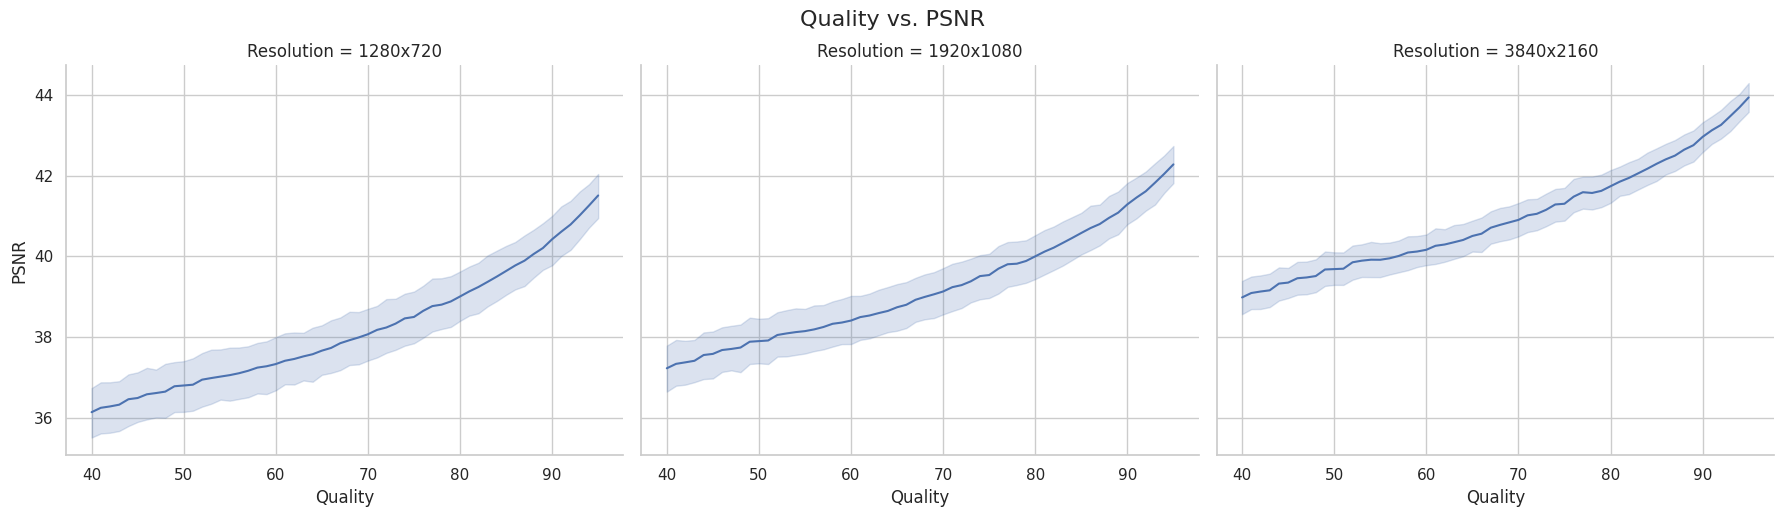

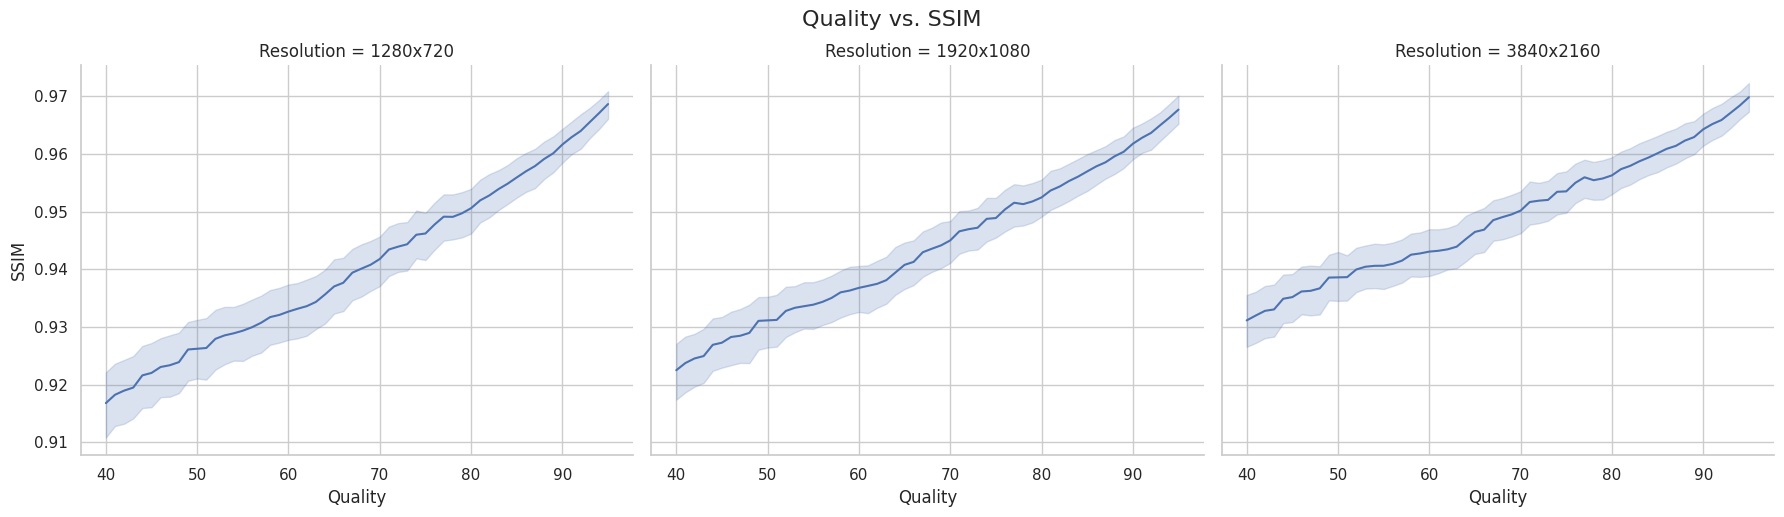

In [18]:
x = 'Quality'
y = 'PSNR'

g = sns.relplot(
    data=df,
    x=x,
    y=y,
    #hue='Frame',
    kind='line',
    height=5,
    aspect=1.2,
    col='Resolution',
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharex': False}
)

g.figure.suptitle(f'{x} vs. {y}', y=1.03, fontsize=16)
g.set_axis_labels(x, y)
plt.show()

x = 'Quality'
y = 'SSIM'

g = sns.relplot(
    data=df,
    x=x,
    y=y,
    #hue='Frame',
    kind='line',
    height=5,
    aspect=1.2,
    col='Resolution',
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharex': False}
)

g.figure.suptitle(f'{x} vs. {y}', y=1.03, fontsize=16)
g.set_axis_labels(x, y)
plt.show()

## Encoding Parameters vs. File Size


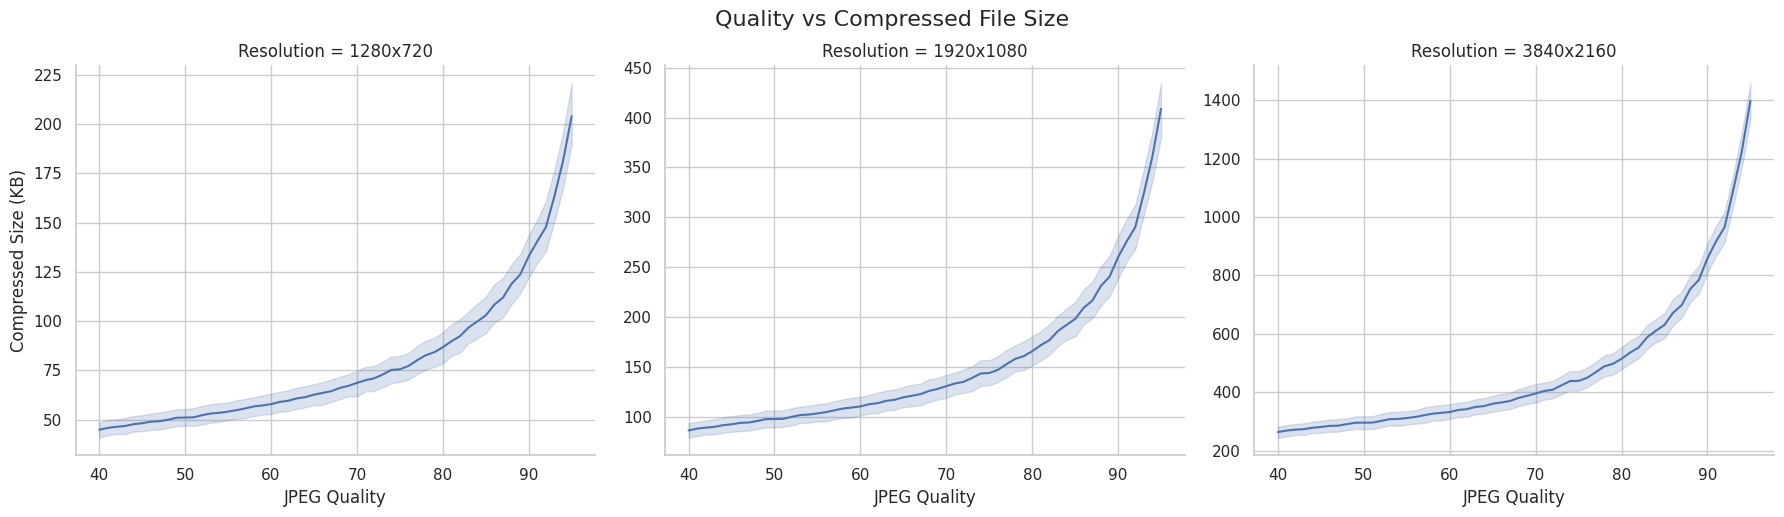

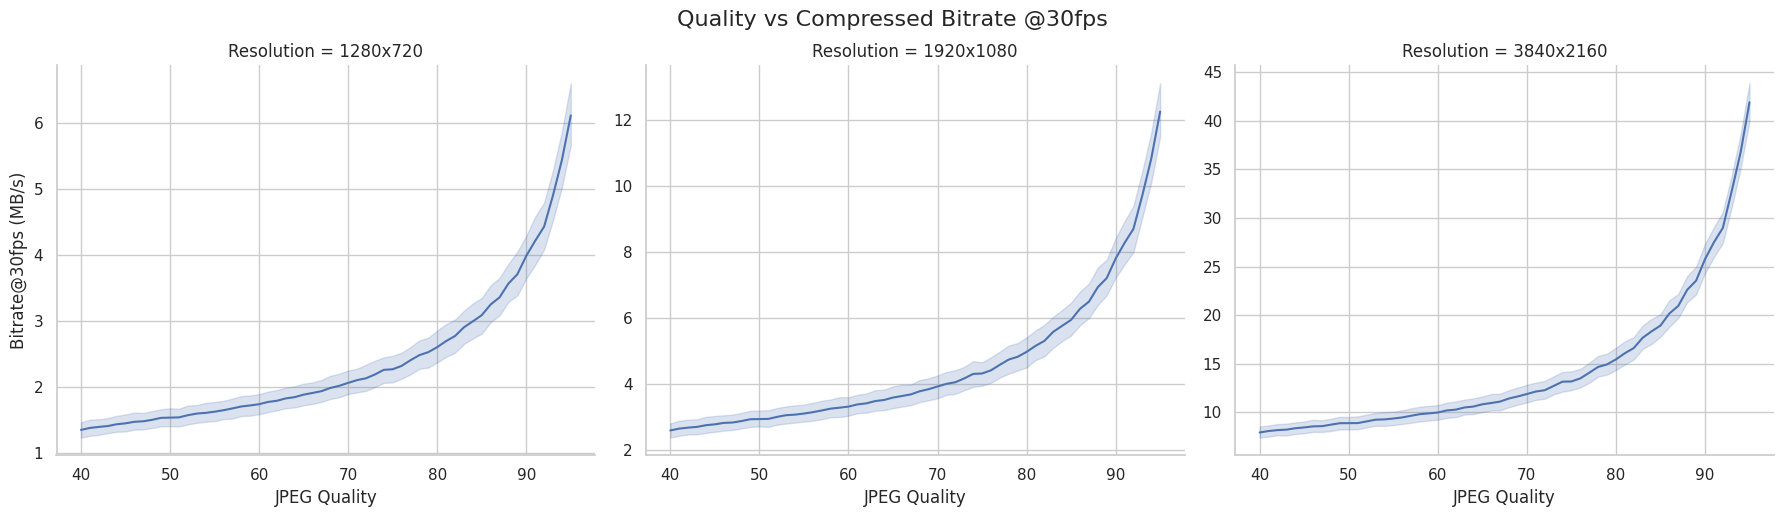

In [19]:
g = sns.relplot(
    data=df,
    x='Quality',
    y='Compressed Size (KB)',
    #hue='Frame',
    kind='line',
    height=5,
    aspect=1.2,
    col='Resolution',
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Compressed File Size', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Compressed Size (KB)')
plt.show()

fps = 30
g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Compressed Size (KB)'] * fps / 1000,
    #hue='Frame',
    kind='line',
    height=5,
    aspect=1.2,
    col='Resolution',
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False},
)
g.figure.suptitle(f'Quality vs Compressed Bitrate @{fps}fps', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', f'Bitrate@{fps}fps (MB/s)')
plt.show()

We can observe an explosion in file size from quality 95 onwards, and a sharp increase from quality 90 onwards.

## Encoding Parameters vs. Performance

As we expected, encoding and decoding in 4:2:0 is the fastest, so we will perform our remaining analysis fixed on this subsampling setting.

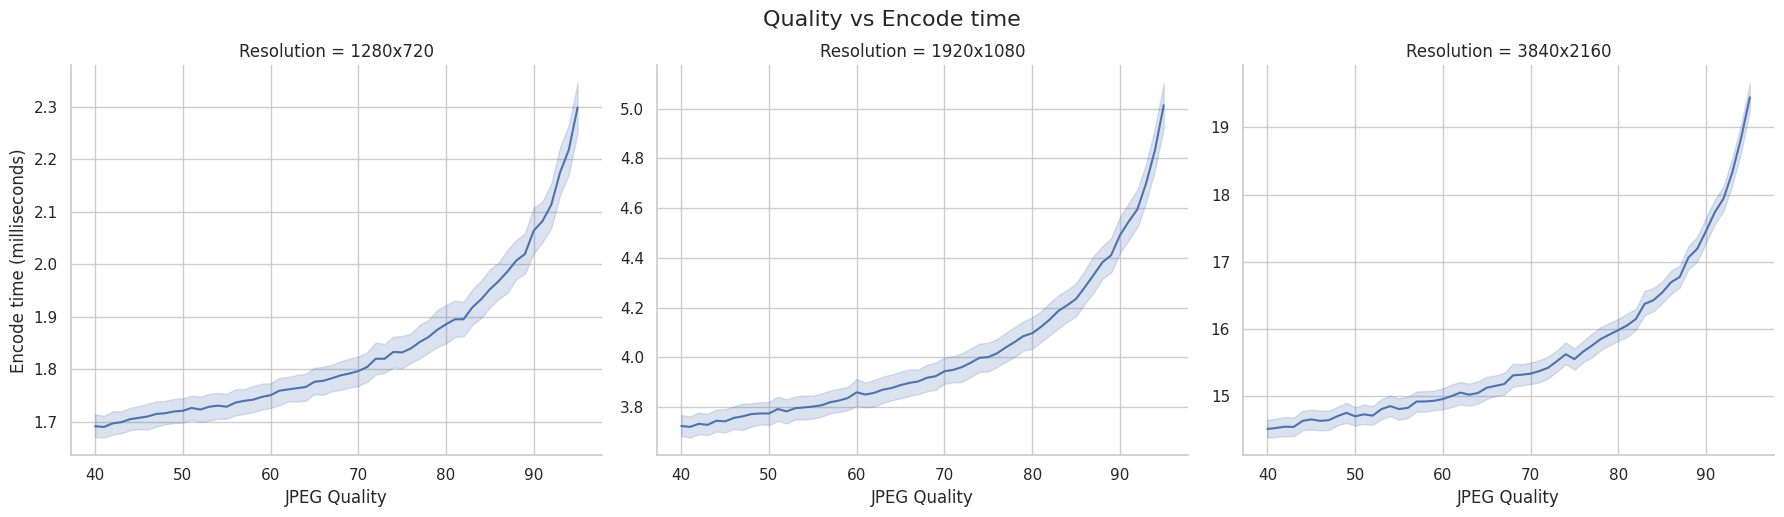

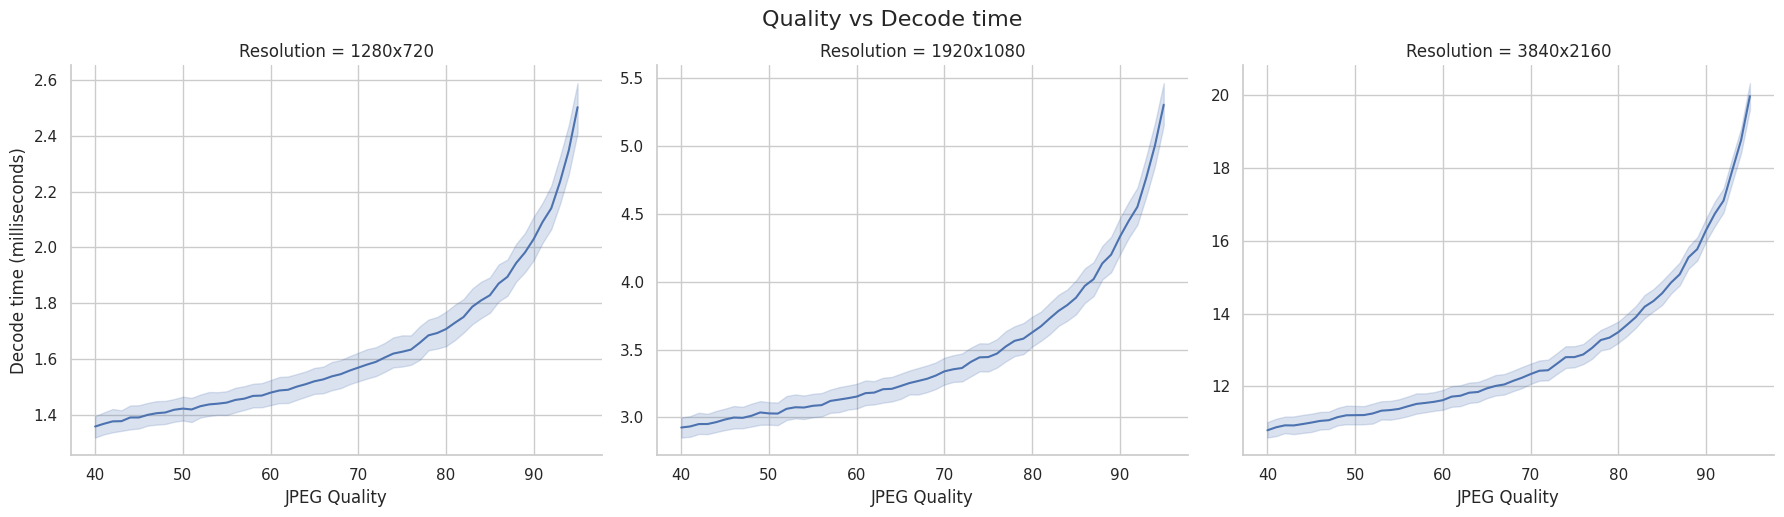

In [20]:
g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Avg Encode Time (s)'] * 1000,
    #hue='Frame',
    kind='line',
    height=5,
    aspect=1.2,
    col='Resolution',
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Encode time', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Encode time (milliseconds)')
plt.show()

g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Avg Decode Time (s)'] * 1000,
    #hue='Frame',
    kind='line',
    height=5,
    aspect=1.2,
    col='Resolution',
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Decode time', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Decode time (milliseconds)')
plt.show()

### Perform average avross frames

In [21]:
df_agg = df.groupby(['Quality', 'Resolution']).agg({
    #'Quality': 'first',  # kept as-is (assuming same value across group)
    'Avg Encode Time (s)': 'mean',    # averaged
    'Avg Decode Time (s)': 'mean',
    'Compressed Size (KB)': 'mean',
    'PSNR': 'mean',
    'SSIM': 'mean',
}).reset_index()

In [22]:
df_agg[df_agg['Avg Encode Time (s)'] * 1000 + df_agg['Avg Decode Time (s)'] * 1000 <= 2 * 2].sort_values(by='SSIM', ascending=False).head(5)
#df = df[df['Avg Encode Time (s)'] * 1000 <= 2]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 2]
#df_agg.sort_values(by='SSIM', ascending=False).head(5)

,Quality,Resolution,Avg Encode Time (s),Avg Decode Time (s),Compressed Size (KB),PSNR,SSIM
144,88,1280x720,0.002007,0.001945,118.95437,40.059766,0.959144
141,87,1280x720,0.001986,0.001895,111.95051,39.893571,0.957917
138,86,1280x720,0.001968,0.001871,108.35583,39.775664,0.956996
135,85,1280x720,0.001952,0.001829,102.92296,39.637228,0.955939
132,84,1280x720,0.001933,0.001811,99.81119,39.499541,0.954854


In [23]:
df_agg[df_agg['Avg Encode Time (s)'] * 1000 + df_agg['Avg Decode Time (s)'] * 1000 <= 1.5 * 2].sort_values(by='SSIM', ascending=False).head(5)
#df = df[df['Avg Encode Time (s)'] * 1000 <= 1.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 1.5]
#df.sort_values(by='SSIM', ascending=False).head(5)

,Quality,Resolution,Avg Encode Time (s),Avg Decode Time (s),Compressed Size (KB),PSNR,SSIM


In [24]:
df_agg[df_agg['Avg Encode Time (s)'] * 1000 + df_agg['Avg Decode Time (s)'] * 1000 <= 1.45 * 2].sort_values(by='SSIM', ascending=False).head(5)


,Quality,Resolution,Avg Encode Time (s),Avg Decode Time (s),Compressed Size (KB),PSNR,SSIM


In [25]:
df_agg[df_agg['SSIM'] <= 0.95].sort_values(by='Quality', ascending=False).head(5)


,Quality,Resolution,Avg Encode Time (s),Avg Decode Time (s),Compressed Size (KB),PSNR,SSIM
117,79,1280x720,0.001875,0.001694,84.21465,38.881824,0.949720
114,78,1280x720,0.001861,0.001686,82.70268,38.802496,0.949104
111,77,1280x720,0.001852,0.001659,80.13137,38.766898,0.949130
108,76,1280x720,0.001840,0.001635,77.25872,38.647855,0.947773
105,75,1280x720,0.001832,0.001627,75.56439,38.496712,0.946211
